### **Libraries**

In [2]:
#from google.colab import drive
#drive.mount("/content/drive/")

In [3]:
## Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import difflib
import re
import warnings
import time

## Pipelines (For encoding and scaling)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### **Import data**

In [5]:
# Path data for Sophie
#df_train_transactions_org = pd.read_csv("drive/My Drive/data-in/Train_transactions.csv", low_memory=False, converters={'id_client': str}, parse_dates=['transaction_date'])
#df_test_transactions_org = pd.read_csv("drive/My Drive/data-in/Test_transactions.csv", low_memory=False, converters={'id_client': str}, parse_dates=['transaction_date'])
#df_train_repurchase_org = pd.read_csv("drive/My Drive/data-in/Train_customers_repurchase.csv", low_memory=False, converters={'id_client': str})

In [6]:
df_train_transactions_org = pd.read_csv("data-in/Train_transactions.csv", low_memory=False, converters={'id_client': str}, parse_dates=['transaction_date'])
df_test_transactions_org = pd.read_csv("data-in/Test_transactions.csv", low_memory=False, converters={'id_client': str}, parse_dates=['transaction_date'])
df_train_repurchase_org = pd.read_csv("data-in/Train_customers_repurchase.csv", low_memory=False, converters={'id_client': str})

In [126]:
df_train_transactions = df_train_transactions_org.copy(deep=True)
df_test_transactions = df_test_transactions_org.copy(deep=True)
df_train_repurchase = df_train_repurchase_org.copy(deep=True)

df_train_transactions.head()

,id_client,transaction_date,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,email_domain,civility,zip_code,card_subscription,multicard,price_segmentation
0,0037520523,2019-12-26 16:44:00+00:00,12015,57,138.69,0.49,138.20,0,0,1,0,NaN,MME,12420,NaN,0.0,NaN
1,0084917629,2019-08-01 12:16:00+00:00,77131,6,9.87,0.00,9.87,0,0,1,0,NaN,MME,77450,NaN,0.0,NaN
2,0020962900,2019-09-25 18:10:00+00:00,92786,6,26.25,2.21,24.04,0,0,0,1,GMAIL.COM,MME,92110,NaN,0.0,Quali
3,0085917543,2020-01-24 17:34:00+00:00,21554,5,15.08,0.00,15.08,0,0,0,1,SFR.FR,M,21130,NaN,0.0,Mixte
4,0006861392,2019-08-22 19:28:00+00:00,83820,25,81.16,30.60,50.56,0,0,0,1,ORANGE.FR,MME,83600,NaN,0.0,Mixte


## **I. Data exploration and pre-processing**

The train data set about transations (*df_train_transations*) has 17 columns and 3298736 rows.

The train data set about transations (*df_train_repurchase*) has 2 columns and 160424 rows. The columns are the ID_client  and the target variable : **Repurchase**. We have previously merge df_train_repurchase and df_train_transactions in one dataset by the id_client: **df_train**.

Our test dataset has 824282 rows and 17 columns, but here we don't have the target variable response.

### **I.1 Descriptive statistics**

In [8]:
## MEAN OF PAYMENT

print(round(df_train_transactions.payment_gift.sum()/len(df_train_transactions)*100,2),'% of the transactions were paid with gift')
print(round(df_train_transactions.payment_cheque.sum()/len(df_train_transactions)*100,2),'% of the transactions were paid with cheque')
print(round(df_train_transactions.payment_cash.sum()/len(df_train_transactions)*100,2),'% of the transactions were paid with cash')
print(round(df_train_transactions.payment_card.sum()/len(df_train_transactions)*100,2),'% of the transactions were paid with card')

6.92 % of the transactions were paid with gift
3.35 % of the transactions were paid with cheque
22.7 % of the transactions were paid with cash
67.81 % of the transactions were paid with card


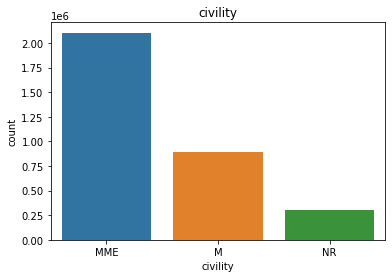

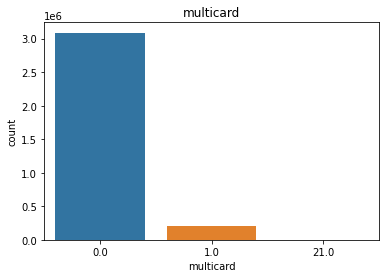

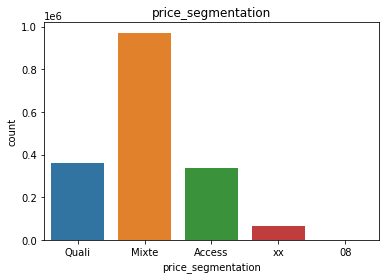

In [9]:
#Countplot for each categorical variable
categorical_list=['civility', 'multicard', 'price_segmentation']

for i in categorical_list:
    plt.figure()
    sns.countplot(x = i, data = df_train_transactions)
    plt.title(i)

**COMMENTS:** 



*   About 50% of the price segmentation are Mixte, then about 20% are Quali and 20% Access. 
*   The majority of the transactions were made by woman (about 50%)
*   There is perhaps here have abnormal values (08 for price segmentation and 21 for multicard).





In [10]:
numerical_list=['item_count','gross_amount','discount_amount','basket_value']
df_train_transactions.describe()

,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,multicard
count,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.292217e+06
mean,4.467323e+04,1.598724e+01,5.057524e+01,3.494432e+00,4.708081e+01,6.917104e-02,3.350435e-02,2.269836e-01,6.780846e-01,6.233611e-02
std,2.842219e+04,1.733723e+01,6.290823e+01,1.062924e+01,5.673420e+01,2.537448e-01,1.799495e-01,4.188820e-01,4.672108e-01,2.531078e-01
min,1.238000e+03,-2.880000e+02,-2.602980e+03,-1.131970e+03,-2.342680e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000100e+04,5.000000e+00,1.323000e+01,0.000000e+00,1.291000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.820600e+04,1.000000e+01,3.024000e+01,0.000000e+00,2.919000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,7.334200e+04,2.100000e+01,6.783000e+01,2.250000e+00,6.227000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,9.963400e+04,2.159000e+03,2.306485e+04,2.837370e+03,2.022748e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.100000e+01


**COMMENTS:**

*   The mean count of item is 16. There is some outliers (negative values like -260, and extreme values like 230).
*   The average gross amount is 51 euros. Outliers: negative (-263) and extreme values (2306).
*   The average discount amount is 3.49 euros. Outliers: negative (-113) and exteme values (2837).
*   The average basket valoue is 47 euros. Outliers: negative (-234) and extreme values (2022).




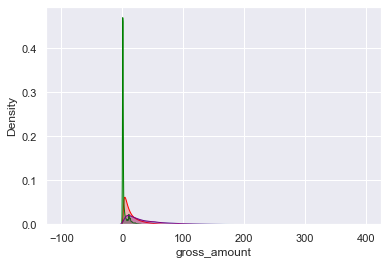

In [11]:
## GRAPH DENSITY

sns.set(style="darkgrid")
 
# density plot with shaded area with kdeplot 'shade' parameter
sns.kdeplot(df_train_transactions['gross_amount'], shade=True, color="skyblue", clip  = (-100,400))
sns.kdeplot(df_train_transactions['item_count'], shade=True, color="red", clip  = (-50,125))
sns.kdeplot(df_train_transactions['discount_amount'], shade=True, color="green", clip  = (-50,30))
sns.kdeplot(df_train_transactions['basket_value'], shade=True, color="purple", clip  = (-100,400))
plt.show()

### **I.2 Missing values**

<AxesSubplot:>

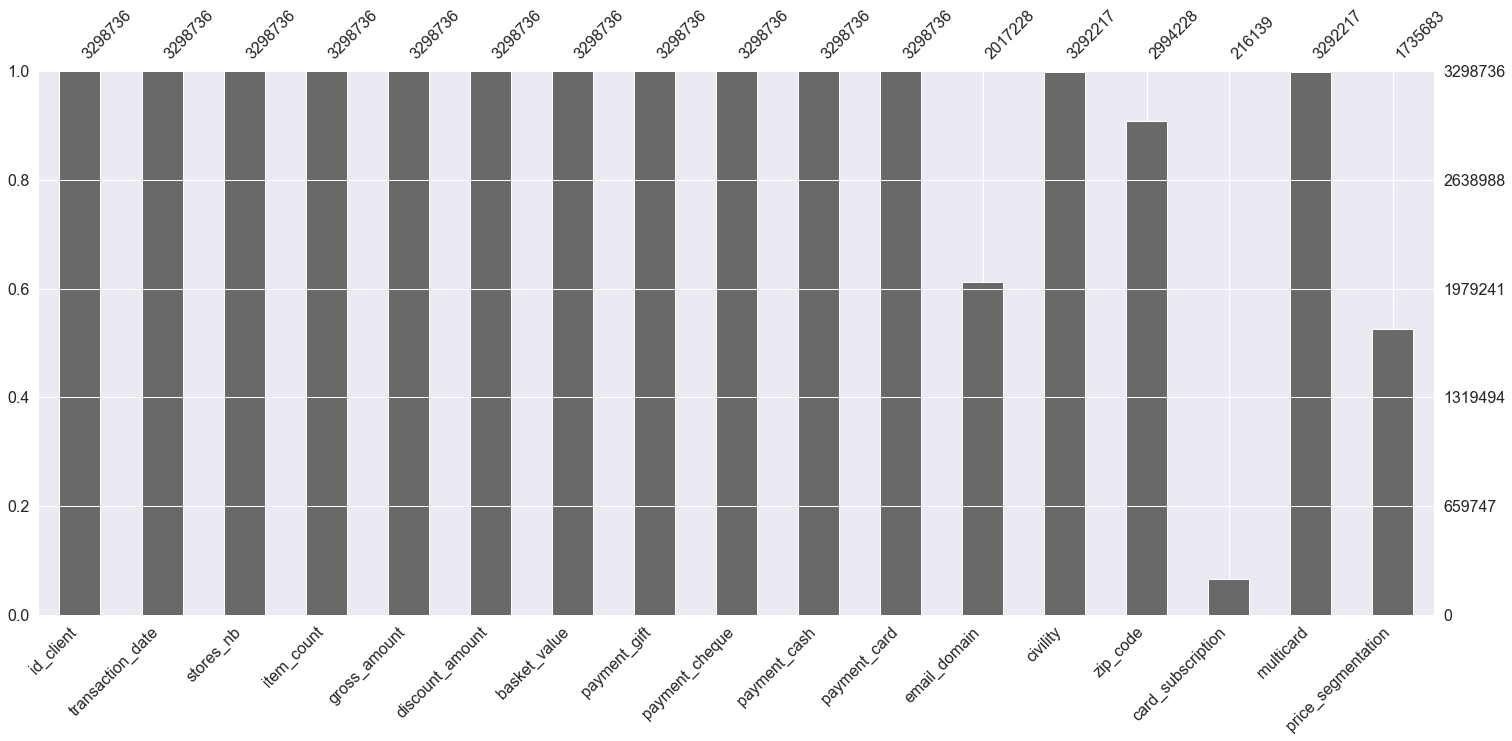

In [12]:
msno.bar(df_train_transactions)  

**COMMENTS:** 


*   We have no missing values for the majority of our features.
*   email domain and price segmentation have respectively about 40 and 50% of missing values. 
*   card_subscription can't be used in our model because there is more than 90% of missing values in it.

If we compare this with the missing values in the test dataset we can see that card subscription variable in test dataset has more than 90% of missing values so it is definitely not interesting to include it in our prediction model. Furthermore price segmentation and email domain have also 40/50% of missing values in test dataset. There use in the model may be discutable.


### **I.3 Outliers**

#### Rules to identify outliers

We will define several rules for the outliers: 

*   The weird 44 observations we saw previoulsy will be removed.
*   We will consider POSSIBLY as outliers, values that are outside the interval [Q25% - 6*[Q75% – Q25%],  Q75% + 6*(Q75% – Q25%)]

Why this interval ? Because we have **extreme values** and the **distribution are skewed**, not normal distribution, so we use the quartiles Q25% - 6*[Q75% – Q25%] and Q75% + 6*[Q75% – Q25%] as used similarly (but with 3 not 6) in the boxplot. We will adjust this interval if we see that in some variables with unsual distribution (really skewed) it is not working well those bounds



In [13]:
def limit(x):
    return round((np.percentile(x, 75) + 6*(np.percentile(x, 75) - np.percentile(x, 25)) ),2),round((np.percentile(x, 25) - 6*(np.percentile(x, 75) - np.percentile(x, 25)) ),2)

print('Sup limit of item_count:' ,limit(df_train_transactions.item_count))   # = (117.0, -91),  ok
print('Sup limit of gross_amount:' ,limit(df_train_transactions.gross_amount))  # = (395.43, -314.37) , ok
print('Sup limit of discount_amount:' ,limit(df_train_transactions.discount_amount))  # = (15.75, -13.5), not ok. We will set it (200,-200) : the distribution has a very long tail. There can be some exceptional discount.
print('Sup limit of basket_value:' ,limit(df_train_transactions.basket_value))  # = (358.43, -283.25) , ok

Sup limit of item_count: (117.0, -91.0)
Sup limit of gross_amount: (395.43, -314.37)
Sup limit of discount_amount: (15.75, -13.5)
Sup limit of basket_value: (358.43, -283.25)


In [14]:
## Sup limit
sup_item = 117
sup_gross_amount = 395
sup_discount_amount = 200
sup_basket = 358

## Inf limit
inf_item = -91
inf_gross_amount = -314
inf_discount_amount = -200
inf_basket = -283

#### Cleaning

In [35]:
# We replace the outliers by NA

df_train_transactions['item_count'] =  np.where((df_train_transactions['item_count']<inf_item) | (df_train_transactions['item_count']>sup_item),np.nan,df_train_transactions['item_count']) 
df_train_transactions['gross_amount'] =  np.where((df_train_transactions['gross_amount']<inf_gross_amount) | (df_train_transactions['gross_amount']>sup_gross_amount),np.nan,df_train_transactions['gross_amount']) 
df_train_transactions['discount_amount'] =  np.where((df_train_transactions['discount_amount']<inf_discount_amount) | (df_train_transactions['discount_amount']>sup_discount_amount),np.nan,df_train_transactions['discount_amount']) 
df_train_transactions['basket_value'] =  np.where((df_train_transactions['basket_value']<inf_basket) | (df_train_transactions['basket_value']>sup_basket),np.nan,df_train_transactions['basket_value']) 

print(round(sum(df_train_transactions.item_count.isna())/len(df_train_transactions)*100,2),'% of values in item_count are NA now.')
print(round(sum(df_train_transactions.gross_amount.isna())/len(df_train_transactions)*100,2),'% of values in gross_amount are NA now.')
print(round(sum(df_train_transactions.discount_amount.isna())/len(df_train_transactions)*100,2),'% of values in discount_amount are NA now.')
print(round(sum(df_train_transactions.basket_value.isna())/len(df_train_transactions)*100,2),'% of values in basket_value are NA now.')

0.15 % of values in item_count are NA now.
0.24 % of values in gross_amount are NA now.
0.02 % of values in discount_amount are NA now.
0.26 % of values in basket_value are NA now.


### **I.4 Mispelling and other errors**

#### Mail cleaning

There is a lot of  domains that are mispelled like for instance OORANGE, thus we defined a list of "good" domains and we will clean the domains names.


In [16]:
good_domains = ['GMAIL.COM','HOTMAIL.FR', 'ORANGE.FR', 'WANADOO.FR', 'YAHOO.FR', 'FREE.FR', 'HOTMAIL.COM', 'SFR.FR',
               'LAPOSTE.NET', 'LIVE.FR', 'NEUF.FR', 'OUTLOOK.FR', 'AOL.COM', 'BBOX.FR', 'YAHOO.COM', 'ICLOUD.COM',
               'CLUB-INTERNET.FR', 'ALICEADSL.FR', 'MSN.COM', 'NUMERICABLE.FR', 'OUTLOOK.COM', 'VOILA.FR','CEGETEL.NET',
               'DBMAIL.COM', 'GMX.FR', 'GMAIL.FR', 'ME.COM', 'LIBERTYSURF.FR', 'NOOS.FR', 'TELE2.FR', 'MAIL.RU',
               'YMAIL.COM', 'AOL.FR', '9ONLINE.FR', 'LIVE.COM', 'TISCALI.FR', 'NETCOURRIER.COM', 'CARAMAIL.COM',
               'INFONIE.FR', 'HOTMAIL.IT', 'NUMERICABLE.COM', 'YAHOO.IT', 'QQ.COM', 'LAPOSTE.FR', 'ORANGE.COM',
               'WORLDONLINE.FR', 'CLUB.FR', 'FREESBEE.FR', 'AKEONET.COM', 'MAC.COM', 'BLUEWIN.CH', 'ROCKETMAIL.COM',
               'LIVE.COM.PT', 'YAHOO.CO.UK', 'MAIL.COM', 'GMX.COM', 'LIBERO.IT', 'DARTYBOX.COM','YOPMAIL.COM',
               'YAHOO.CO.JP', 'YAHOO.ES', 'LIVE.IT', 'HOTMAIL.BE', 'LYNX-OPTIQUE.COM', 'HOTMAIL.CO.UK', 'YANDEX.RU',
               'GROUPE-CASINO.FR',  'AC-TOULOUSE.FR', 'PANDORA.FR', 'BNPPARIBAS.FR', 'PROTONMAIL.FR', 'SNCF.FR', 'DANONE.FR', 'CAPGEMINI.FR'
               'POLE-EMPLOI.FR', 'EDF.FR', 'DAYDREAM.ORG', 'CHU-BORDEAUX.FR', 'KPMG.FR']
domains = [item.split('.')[0] for item in good_domains]
domains = list(set(domains))

def pre_clean_email(x):
    x = x.split(".")[0]
    if len(x) != 0:
        return x
    else:
        return np.nan
    
    
def similarity(domain, domain_compare):
        if (abs(len(domain) - len(domain)) <= 4) and (domain[0] == domain_compare[0]):
            seq = difflib.SequenceMatcher(None, domain_compare , domain)
            d = seq.ratio()*100
            if 100 > d > 75 :
                return 'similar'
            else:
                return 'not_similar'
        else:
            return 'not_similar'
        
def cleanup_spelling_abbrev(text, replacements):
    replacements = replacements
    for i, j in replacements:
        if text in i:
            return j
    return text


def clean_up_email(df_train):  
    df_train.email_domain = df_train.email_domain.apply(lambda x: pre_clean_email(x) if isinstance(x, str) else x)
    
    replacements = []
    df_domain = df_train[(pd.notnull(df_train.email_domain))].loc[:,['email_domain']]
    
    for domain_compare in domains:
        df_domain['similarities'] = df_domain.email_domain.apply(lambda domain: similarity(domain, domain_compare))
        df_domain['results'] = df_domain[(df_domain.similarities == 'similar')].loc[:,['email_domain']]
        ls_to_replaces  =  list(set(df_domain.results.to_list()))
        ls_to_replaces.remove(np.nan)
        if len(ls_to_replaces):
            replacements.append([ls_to_replaces, domain_compare])
        df_domain = df_domain.drop(['similarities', 'results'],axis=1)
    df_train.email_domain = df_train.email_domain.apply(lambda text: cleanup_spelling_abbrev(text, replacements))
    
    return df_train

### **I.5 Data pre-processing**

Cleaning the data

In [127]:
## REGION

## Sup limit
sup_item = 117
sup_gross_amount = 395
sup_discount_amount = 200
sup_basket = 358

## Inf limit
inf_item = -91
inf_gross_amount = -314
inf_discount_amount = -200
inf_basket = -283

# dictionnaire Departement <-> Region
dict_region = {
    'Auvergne-Rhône-Alpes':[1,3,7,15,26,38,42,43,63,69,73,74],
    'Bourgogne-Franche-Comté':[21,25,39,58,70,71,89,90],
    'Bretagne':[22,29,35,56],
    'Centre-Val de Loire':[18,28,36,37,41,45],
    'Corse':[20,'2A','2B'],
    'Grand Est':[8,10,51,52,54,55,57,67,68,88],
    'Hauts-de-France':[2,59,60,62,80],
    'Île-de-France':[75,77,78,91,92,93,94,95],
    'Normandie':[14,27,50,61,76],
    'Nouvelle-Aquitaine':[16,17,19,23,24,33,40,47,64,79,86,87],
    'Occitanie':[9,11,12,30,31,32,34,46,48,65,66,81,82],
    'Pays de la Loire':[44,49,53,72,85],
    'Provence-Alpes-Côte Azur':[4,5,6,13,83,84]
}
inv_dict_region = {str(val): key for key, values in dict_region.items() for val in values}

col_name_info = ["email_domain", "civility", "region", "multicard", "price_segmentation", "is_sub"]

# Normalize all the column with several fix for each columns
def clean_columns(df):

    # Month and year of the transaction
    df['month_year'] = df.transaction_date.apply(lambda date: str(date.month) + '_' + str(date.year))

    # Departement of the store
    # Its appear that the first two number of the strores_nb is the departement
    df['dep_store'] = df.stores_nb.astype(str).str.zfill(5).str[:2]
    
    # Departement of the client
    df['dep'] = df.zip_code.str.zfill(5).str[:2]
    df.loc[~df.dep.isin(inv_dict_region.keys()), 'dep'] = np.nan
    
    # local_purchase : 1 if client bought in his departement
    df['local_purchase'] = np.where(df.dep == df.dep_store, 1, 0).astype(int)
    
    # Transaction day : day to the last purchase until now
    df['transaction_days'] = pd.TimedeltaIndex(df.transaction_date.max() - df.transaction_date).days
    
    # last_transaction_days : day interval between the next purchase
    df.sort_values(['id_client', 'transaction_days'], inplace=True)
    df['last_transaction_days'] = df.groupby("id_client").transaction_days.diff()
    df['last_transaction_days'] = np.where(df.last_transaction_days.isna(), df.transaction_days, df.last_transaction_days)
    
    # Month of the transaction
    df['month'] = pd.DatetimeIndex(df.transaction_date).month
    
    # An indicator which is 1 if client use discount
    df["discount"] = np.where(df.discount_amount==0, 0, 1)
    
    # An indicator which is equal to 1 if client refund article (negative value)
    df['refunded'] = np.where(df.basket_value < 0, 1, 0)
    
    # Gross amount and  weighted with the recency of the purchase
    df["gross_amount_weight"] = weight_fct(df["gross_amount"], df["transaction_days"])


# We separte the information on the clients in a new table
def info_client_table(df):
    df = df.groupby("id_client").first().reset_index()
    
    # Fill na to take acount the NA value
    df['email_domain'] = df['email_domain'].fillna("AUCUN")
    df['price_segmentation'] = df['price_segmentation'].fillna("NO_SEG")
    df.loc[df.price_segmentation == "08", 'price_segmentation'] = "NO_SEG"
    df['civility'] = df['civility'].fillna("NR")
    
    # Get the region thanks to the dep
    df['region'] = df.dep.map(inv_dict_region).fillna("Autres")
    
    # Fix Outlier values of multicard
    df['multicard'] = df['multicard'].fillna(0).astype(int).map({21:1, 1:1, 0:0}).astype(int)

    # Get the subscription_days and the fact that client is subscribe or not
    df.card_subscription = pd.to_datetime(df.card_subscription, errors='coerce')
    df['subscription_days'] = pd.TimedeltaIndex(df.card_subscription.max() - df.card_subscription).days
    df['is_sub'] = np.where(df.card_subscription.isna(), 0, 1)
    
    # Clean mail and keep the top 10 of mail address
    df = clean_up_email(df)
    top_email_names = df.email_domain.value_counts().head(10).index
    df.loc[~df.email_domain.isin(top_email_names), 'email_domain'] = "Others"
    
    return df[['id_client'] + col_name_info]

In [128]:
# Clean the column
clean_columns(df_train_transactions)
clean_columns(df_test_transactions)

# Exctract the repeated information aboout the client
df_train_info_client = info_client_table(df_train_transactions)
df_test_info_client = info_client_table(df_test_transactions)

df_train_info_client.head()

,id_client,email_domain,civility,region,multicard,price_segmentation,is_sub
0,0000000291,AUCUN,MME,Île-de-France,0,Quali,0
1,0000000365,GMAIL,M,Île-de-France,0,Quali,0
2,0000001800,Others,MME,Île-de-France,0,Mixte,0
3,0000003471,AUCUN,MME,Île-de-France,0,Mixte,0
4,0000003961,WANADOO,MME,Île-de-France,0,NO_SEG,0


### **I.6 Indicators**

The objective is to aggregate the transactions datasets into a client level table. To do that we will use severals indicators describe in the code.

In [19]:
# A function for reorder the cluster of the kmeans
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [73]:
int(False)

0

In [152]:
from sklearn.cluster import KMeans

def weight_fct(x,y):
    return x*(max(y)-y)

# A function to calcultate all the Indicator used for the model
def aggregate_table(df_train_transactions):
    # Aggregation of all the Indicator that we will use
    df_train_RFM = df_train_transactions.groupby('id_client').agg(
        recency=("transaction_days", "min"),
        recency_2p=("transaction_days", lambda x: 365 if x.shape[0] < 2 else x.sort_values().iloc[1]),
        recency_3p=("transaction_days", lambda x: 365 if x.shape[0] < 3 else x.sort_values().iloc[2]),
        #recency_4p=("transaction_days", lambda x: 365 if x.shape[0] < 4 else x.sort_values().iloc[3]),
        #recency_5p=("transaction_days", lambda x: 365 if x.shape[0] < 5 else x.sort_values().iloc[4]),
        #recency_6p=("transaction_days", lambda x: 365 if x.shape[0] < 6 else x.sort_values().iloc[5]),
        recency_10p=("transaction_days", lambda x: 365 if x.shape[0] < 10 else x.sort_values().iloc[9]),
        recency_20p=("transaction_days", lambda x: 365 if x.shape[0] < 20 else x.sort_values().iloc[19]),
        recency_mean=("transaction_days", "mean"),
        frequency=("id_client", "count"),
        frequency_1m=("month", lambda x: x[x <= 1].count()),
        frequency_2m=("month", lambda x: x[x <= 2].count()),
        monetary=("basket_value", "sum"),
        monetary_mean=("basket_value", "mean"),
        monetary_weight=("gross_amount_weight", "sum"),
        frequency_weight=("transaction_days", "sum"),
        item_sum=("item_count", "sum"),
        item_mean=("item_count", "mean"),
        item_max=("item_count", "max"),
        last_transaction_days_mean=("last_transaction_days", "mean"),
        last_transaction_days_max=("last_transaction_days", "max"),
        last_transaction_days_std=("last_transaction_days", "std"),
        discount_sum=("discount_amount", "sum"),
        discount=("discount", "mean"),
        refunded=("refunded", "max"),
        local_purchase=("local_purchase", "mean"),
        nb_store=("stores_nb", "nunique"),
        part_top_store=("stores_nb", lambda x: x.value_counts().max()/x.shape[0]),
        top_store=("stores_nb", lambda x: pd.Series.mode(x)[0]),
        nb_repurchase=("month", "nunique"),
        payment_gift=("payment_gift", "mean"),
        payment_card=("payment_card", "mean"),
        payment_cheque=("payment_cheque", "mean"),
        payment_cash=("payment_cash", "mean"),
        cont_last_1_months=("month", lambda x: int(set([1]).issubset(set(x)))),
        cont_last_2_months=("month", lambda x: int(set([1,2]).issubset(set(x)))),
        cont_last_3_months=("month", lambda x: int(set([1,2,3]).issubset(set(x)))),
        cont_last_4_months=("month", lambda x: int(set([1,2,3,4]).issubset(set(x)))),
    ).reset_index()
    
    df_train_RFM['last_transaction_days_std'] = df_train_RFM['last_transaction_days_std'].fillna(0)
    df_train_RFM['top_store_client'] = df_train_RFM.top_store.map(df_train_RFM.top_store.value_counts())

    # local_purchase_cluster indicator
    # Multi : 
    
    df_train_RFM["local_purchase_cluster"] = "Multi"
    df_train_RFM.loc[df_train_RFM.local_purchase == 1, "local_purchase_cluster"] = "One_dep"
    df_train_RFM.loc[df_train_RFM.local_purchase == 0, "local_purchase_cluster"] = "No_dep"

    # A small RFM segmentation
    kmeanModel_recency = KMeans(n_clusters=3)
    kmeanModel_frequency = KMeans(n_clusters=4)
    kmeanModel_monetary = KMeans(n_clusters=4)
    kmeanModel_recency.fit(df_train_RFM[["recency"]])
    kmeanModel_frequency.fit(df_train_RFM[["frequency"]])
    kmeanModel_monetary.fit(df_train_RFM[["monetary"]])
    df_train_RFM['recency_cluster'] = kmeanModel_recency.predict(df_train_RFM[["recency"]])
    df_train_RFM['frequency_cluster'] = kmeanModel_frequency.predict(df_train_RFM[["frequency"]])
    df_train_RFM['monetary_cluster'] = kmeanModel_monetary.predict(df_train_RFM[["monetary"]])
    df_train_RFM = order_cluster(df_train_RFM, 'recency', 'recency_cluster', False)
    df_train_RFM = order_cluster(df_train_RFM, 'frequency', 'frequency_cluster', True)
    df_train_RFM = order_cluster(df_train_RFM, 'monetary', 'monetary_cluster', True)
    df_train_RFM['score_cluster'] = df_train_RFM['recency_cluster'] + df_train_RFM['frequency_cluster'] + df_train_RFM['monetary_cluster']
    
    # Select the segment thanks to the score
    df_train_RFM.loc[df_train_RFM.score_cluster < 3, 'RFM'] = "Low"
    df_train_RFM.loc[(df_train_RFM.score_cluster < 6) & (df_train_RFM.score_cluster >= 3), 'RFM'] = "Medium"
    df_train_RFM.loc[df_train_RFM.score_cluster >= 6, 'RFM'] = "Hight"

    # Drop ununcessary features
    df_train_RFM.drop(['top_store', 'recency_cluster', 'frequency_cluster', 'monetary_cluster', 'score_cluster'], axis=1, inplace=True)
    
    return df_train_RFM

df_train = aggregate_table(df_train_transactions).merge(df_train_info_client, on="id_client").merge(df_train_repurchase, on="id_client")
df_test = aggregate_table(df_test_transactions).merge(df_test_info_client, on="id_client")

df_train.head()

,id_client,recency,recency_2p,recency_3p,recency_10p,recency_20p,recency_mean,frequency,frequency_1m,frequency_2m,monetary,monetary_mean,monetary_weight,frequency_weight,item_sum,item_mean,item_max,last_transaction_days_mean,last_transaction_days_max,last_transaction_days_std,discount_sum,discount,refunded,local_purchase,nb_store,part_top_store,nb_repurchase,payment_gift,payment_card,payment_cheque,payment_cash,cont_last_1_months,cont_last_2_months,cont_last_3_months,cont_last_4_months,top_store_client,local_purchase_cluster,RFM,email_domain,civility,region,multicard,price_segmentation,is_sub,repurchase
0,0000000291,0,12,21,69,154,198.472727,55,6,10,4031.44,73.298909,751349.81,10916,1499,27.254545,58,6.618182,14.0,3.493332,119.99,0.363636,0,1.0,1,1.000000,12,0.090909,1.000000,0.0,0.000000,1,1,1,1,204,One_dep,Medium,AUCUN,MME,Île-de-France,0,Quali,0,0
1,0000004943,9,12,12,47,168,212.805195,77,9,16,3158.47,41.019091,480501.70,16386,1231,15.987013,50,4.597403,88.0,9.958149,208.78,0.467532,0,1.0,2,0.922078,10,0.103896,0.909091,0.0,0.025974,1,1,1,0,215,One_dep,Medium,AUCUN,MME,Auvergne-Rhône-Alpes,1,Mixte,0,0
2,0000006009,13,20,28,95,188,206.125000,48,5,7,1914.07,39.876458,343505.98,9894,756,15.750000,30,7.562500,22.0,4.257190,34.31,0.208333,0,1.0,1,1.000000,12,0.000000,0.979167,0.0,0.020833,1,1,1,1,192,One_dep,Medium,HOTMAIL,M,Île-de-France,0,Quali,0,0
3,0000006786,1,3,4,41,155,196.841270,63,6,13,1633.06,25.921587,289276.28,12401,664,10.539683,24,5.746032,67.0,8.741758,38.99,0.333333,0,1.0,2,0.920635,11,0.047619,1.000000,0.0,0.000000,1,1,1,0,85,One_dep,Medium,AUCUN,MME,Bretagne,0,Mixte,0,0
4,0000008991,3,7,16,49,84,165.847059,85,10,19,3078.21,36.214235,606365.17,14097,1088,12.800000,31,3.870588,14.0,2.374408,7.23,0.082353,0,0.0,5,0.823529,11,0.011765,0.894118,0.0,0.105882,1,1,1,1,405,No_dep,Medium,AUCUN,MME,Autres,0,Quali,0,0


In [151]:
df_train

,id_client,recency,recency_2p,recency_3p,recency_10p,recency_20p,recency_mean,frequency,frequency_1m,frequency_2m,monetary,monetary_mean,monetary_weight,frequency_weight,item_sum,item_mean,item_max,last_transaction_days_mean,last_transaction_days_max,last_transaction_days_std,discount_sum,discount,refunded,local_purchase,nb_store,part_top_store,nb_repurchase,payment_gift,payment_card,payment_cheque,payment_cash,cont_last_1_months,cont_last_2_months,cont_last_3_months,cont_last_4_months,top_store_client,local_purchase_cluster,RFM,email_domain,civility,region,multicard,price_segmentation,is_sub,repurchase
0,0000000291,0,12,21,69,154,198.472727,55,1,2,4031.44,73.298909,751349.81,10916,1499,27.254545,58,6.618182,14.0,3.493332,119.99,0.363636,0,1.000000,1,1.000000,12,0.090909,1.000000,0.000000,0.000000,1,1,1,1,204,One_dep,Medium,AUCUN,MME,Île-de-France,0,Quali,0,0
1,0000004943,9,12,12,47,168,212.805195,77,1,2,3158.47,41.019091,480501.70,16386,1231,15.987013,50,4.597403,88.0,9.958149,208.78,0.467532,0,1.000000,2,0.922078,10,0.103896,0.909091,0.000000,0.025974,1,1,1,0,215,One_dep,Medium,AUCUN,MME,Auvergne-Rhône-Alpes,1,Mixte,0,0
2,0000006009,13,20,28,95,188,206.125000,48,1,2,1914.07,39.876458,343505.98,9894,756,15.750000,30,7.562500,22.0,4.257190,34.31,0.208333,0,1.000000,1,1.000000,12,0.000000,0.979167,0.000000,0.020833,1,1,1,1,192,One_dep,Medium,HOTMAIL,M,Île-de-France,0,Quali,0,0
3,0000006786,1,3,4,41,155,196.841270,63,1,2,1633.06,25.921587,289276.28,12401,664,10.539683,24,5.746032,67.0,8.741758,38.99,0.333333,0,1.000000,2,0.920635,11,0.047619,1.000000,0.000000,0.000000,1,1,1,0,85,One_dep,Medium,AUCUN,MME,Bretagne,0,Mixte,0,0
4,0000008991,3,7,16,49,84,165.847059,85,1,2,3078.21,36.214235,606365.17,14097,1088,12.800000,31,3.870588,14.0,2.374408,7.23,0.082353,0,0.000000,5,0.823529,11,0.011765,0.894118,0.000000,0.105882,1,1,1,1,405,No_dep,Medium,AUCUN,MME,Autres,0,Quali,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160419,0037663079,316,320,320,328,329,345.319767,172,0,0,21619.89,125.697035,485755.60,59395,2693,15.656977,66,2.122093,316.0,24.080328,4520.62,0.988372,1,0.302326,6,0.552326,2,0.674419,0.127907,0.005814,0.767442,0,0,0,0,856,Multi,Medium,GMAIL,MME,Auvergne-Rhône-Alpes,0,NO_SEG,0,0
160420,0038244611,248,248,249,252,259,279.970588,170,0,0,24900.76,146.475059,2705020.94,47595,1751,10.300000,124,1.864706,248.0,19.035919,5520.17,0.994118,1,0.000000,12,0.305882,3,0.629412,0.035294,0.000000,0.323529,0,0,0,0,856,No_dep,Medium,HOTMAIL,NR,Autres,0,Quali,0,0
160421,0018897479,6,6,6,6,18,149.304153,2456,1,2,52667.89,21.444581,14372247.23,366691,22985,9.358713,150,0.148616,10.0,0.642283,11170.19,0.560668,0,0.999593,4,0.998779,12,0.003664,0.256107,0.052524,0.084283,1,1,1,1,46,Multi,Hight,HOTMAIL,MME,Provence-Alpes-Côte Azur,1,xx,0,0
160422,0033665648,2,4,6,6,21,155.594669,2889,1,2,48677.14,16.849131,11654539.69,449513,23014,7.966078,67,0.126341,18.0,0.718976,5871.35,0.385601,0,0.000000,2,0.999308,12,0.004500,0.230183,0.035999,0.069228,1,1,1,1,46,No_dep,Hight,Others,NR,Autres,0,Mixte,0,0


**COMMMENTS:** 

By aggregating, we have gone from more than 3 millions of rows to 160 424 rows. This is more pertinent to analyze aggregated by clients and it will considerably be easier for our computation later.

## **II. Modele**

In [56]:
## Sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, log_loss

## Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

## Model
from lightgbm import LGBMClassifier, plot_importance, plot_metric
from catboost import CatBoostClassifier, MetricVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Catboost
import catboost as cbt

# model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score


### **II.1 Data processing**

In [110]:
df_train_NO_NA = df_train.dropna()
df_test_NO_NA = df_test.dropna()

print("We have gone from",len(df_train),"rows to",len(df_train_NO_NA),'rows in the train dataset')
print("We have gone from",len(df_test),"rows to",len(df_test_NO_NA),'rows in the train dataset')

We have gone from 160424 rows to 160054 rows in the train dataset
We have gone from 40106 rows to 40106 rows in the train dataset


We create a training set (X_train, y_train) and a test set (X_test, y_test)

In [193]:
# Creation of the training and test sets
col_drop = []
df_train_selection = df_train.drop(col_drop, axis=1)
df_test_selected = df_test.drop(col_drop, axis=1)

# To define the input and output feature
X = df_train_selection.drop(['repurchase', 'id_client'], axis=1)
y = df_train_selection.repurchase
X_test_kaggle = df_test_selected.drop(['id_client'], axis=1)

# Encoding for qualitative features with One Hot Encoder
cat_features = X.select_dtypes(exclude=np.number).columns.to_list()
quanti_features = [col for col in X.columns if col not in cat_features]

X = pd.get_dummies(X, columns=cat_features)
X_test_kaggle = pd.get_dummies(X_test_kaggle, columns=cat_features)

# Scalling for quantitative features wither normal scaling
X[quanti_features] = QuantileTransformer().fit_transform(X[quanti_features]) #StandardScaler
X_test_kaggle[quanti_features] = QuantileTransformer().fit_transform(X_test_kaggle[quanti_features]) #StandardScaler

# Convert cat_features to pd.Categorical dtype
for col in cat_features:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #X[col] = pd.Categorical(X[col])
        #X_test_kaggle[col] = pd.Categorical(X_test_kaggle[col])

# Encoded train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=4
)

X_train.head()

,recency,recency_2p,recency_3p,recency_10p,recency_20p,recency_mean,frequency,frequency_1m,frequency_2m,monetary,monetary_mean,monetary_weight,frequency_weight,item_sum,item_mean,item_max,last_transaction_days_mean,last_transaction_days_max,last_transaction_days_std,discount_sum,discount,refunded,local_purchase,nb_store,part_top_store,nb_repurchase,payment_gift,payment_card,payment_cheque,payment_cash,cont_last_1_months,cont_last_2_months,cont_last_3_months,cont_last_4_months,top_store_client,multicard,is_sub,local_purchase_cluster_Multi,local_purchase_cluster_No_dep,local_purchase_cluster_One_dep,RFM_Hight,RFM_Low,RFM_Medium,email_domain_AUCUN,email_domain_FREE,email_domain_GMAIL,email_domain_HOTMAIL,email_domain_LAPOSTE,email_domain_LIVE,email_domain_ORANGE,email_domain_Others,email_domain_SFR,email_domain_WANADOO,email_domain_YAHOO,civility_M,civility_MME,civility_NR,region_Autres,region_Auvergne-Rhône-Alpes,region_Bourgogne-Franche-Comté,region_Bretagne,region_Centre-Val de Loire,region_Corse,region_Grand Est,region_Hauts-de-France,region_Normandie,region_Nouvelle-Aquitaine,region_Occitanie,region_Pays de la Loire,region_Provence-Alpes-Côte Azur,region_Île-de-France,price_segmentation_Access,price_segmentation_Mixte,price_segmentation_NO_SEG,price_segmentation_Quali,price_segmentation_xx
154778,0.866366,0.722723,1.000000,1.000000,1.000000,0.775079,0.211712,0.000000,0.000000,0.017485,0.013038,0.035462,0.267017,0.049550,0.032032,0.045045,0.830330,0.850350,0.971215,0.127127,0.000000,0.0,0.0,0.790791,0.031031,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.334835,0.0,0.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
158854,0.930931,0.778779,0.712713,1.000000,1.000000,0.953129,0.430430,0.000000,0.000000,0.394244,0.420371,0.159091,0.545921,0.405906,0.445445,0.486486,0.657102,0.927928,0.927959,0.482683,0.549049,0.0,1.0,0.000000,1.000000,0.276777,0.000000,0.267768,0.0,0.811311,0.0,0.0,0.0,0.0,0.843844,0.0,0.0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9350,0.139139,0.100601,0.147648,0.094595,0.085085,0.200817,0.865365,0.939439,0.863864,0.910555,0.745612,0.932855,0.813000,0.889389,0.718923,0.850350,0.123608,0.084084,0.261330,0.705183,0.463964,0.0,1.0,0.000000,1.000000,0.844344,0.000000,0.525526,0.0,0.573574,1.0,1.0,1.0,1.0,0.309810,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
151608,0.964965,1.000000,1.000000,1.000000,1.000000,0.958781,0.000000,0.000000,0.000000,0.131404,0.488852,0.061947,0.194194,0.187187,0.681181,0.349349,0.975976,0.964464,0.000000,0.390057,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.972472,0.0,0.0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
79849,0.528028,0.436937,0.367868,0.322322,1.000000,0.252021,0.605606,0.000000,0.605606,0.721787,0.782201,0.745906,0.561311,0.722723,0.806854,0.790290,0.370062,0.241241,0.438654,0.755856,0.787287,0.0,0.0,0.790791,0.109109,0.583083,0.794294,1.000000,0.0,0.557057,0.0,0.0,0.0,0.0,0.593594,0.0,0.0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [148]:
quanti_features

['recency',
 'recency_2p',
 'recency_3p',
 'recency_10p',
 'recency_20p',
 'recency_mean',
 'frequency',
 'frequency_1m',
 'frequency_2m',
 'monetary',
 'monetary_mean',
 'monetary_weight',
 'frequency_weight',
 'item_sum',
 'item_mean',
 'item_max',
 'last_transaction_days_mean',
 'last_transaction_days_max',
 'last_transaction_days_std',
 'discount_sum',
 'discount',
 'refunded',
 'local_purchase',
 'nb_store',
 'part_top_store',
 'nb_repurchase',
 'payment_gift',
 'payment_card',
 'payment_cheque',
 'payment_cash',
 'cont_last_1_months',
 'cont_last_2_months',
 'cont_last_3_months',
 'cont_last_4_months',
 'top_store_client',
 'multicard',
 'is_sub',
 'local_purchase_cluster_Multi',
 'local_purchase_cluster_No_dep',
 'local_purchase_cluster_One_dep',
 'RFM_Hight',
 'RFM_Low',
 'RFM_Medium',
 'email_domain_AUCUN',
 'email_domain_FREE',
 'email_domain_GMAIL',
 'email_domain_HOTMAIL',
 'email_domain_LAPOSTE',
 'email_domain_LIVE',
 'email_domain_ORANGE',
 'email_domain_Others',
 'email

### **II.2 Feature Selection**

#### ***Catboost selection***

In [158]:
fit_params={"eval_set" : (X_test,y_test),
           }

model = cbt.CatBoostClassifier(cat_features=list(X_train.select_dtypes("object").columns),
                               iterations=1000,
                               learning_rate=0.02,
                               objective="Logloss")

model.fit(X_train, y_train, **fit_params)
best_feats = model.get_feature_importance(prettified=True)
ls_best_feats = best_feats[(best_feats.Importances > 0.5)]['Feature Id'].to_list()

0:	learn: 0.6635806	test: 0.6637413	best: 0.6637413 (0)	total: 13.5ms	remaining: 13.5s
1:	learn: 0.6351204	test: 0.6354519	best: 0.6354519 (1)	total: 27.6ms	remaining: 13.7s
2:	learn: 0.6080474	test: 0.6085194	best: 0.6085194 (2)	total: 40.8ms	remaining: 13.5s
3:	learn: 0.5834762	test: 0.5841124	best: 0.5841124 (3)	total: 53.9ms	remaining: 13.4s
4:	learn: 0.5626544	test: 0.5633663	best: 0.5633663 (4)	total: 66.8ms	remaining: 13.3s
5:	learn: 0.5421546	test: 0.5429932	best: 0.5429932 (5)	total: 79.6ms	remaining: 13.2s
6:	learn: 0.5233945	test: 0.5243245	best: 0.5243245 (6)	total: 92.7ms	remaining: 13.1s
7:	learn: 0.5063707	test: 0.5073897	best: 0.5073897 (7)	total: 105ms	remaining: 13.1s
8:	learn: 0.4876962	test: 0.4887921	best: 0.4887921 (8)	total: 119ms	remaining: 13.1s
9:	learn: 0.4703364	test: 0.4715837	best: 0.4715837 (9)	total: 132ms	remaining: 13.1s
10:	learn: 0.4551398	test: 0.4564679	best: 0.4564679 (10)	total: 146ms	remaining: 13.1s
11:	learn: 0.4410979	test: 0.4425157	best: 0.

101:	learn: 0.2027132	test: 0.2071456	best: 0.2071456 (101)	total: 1.38s	remaining: 12.2s
102:	learn: 0.2024793	test: 0.2069258	best: 0.2069258 (102)	total: 1.4s	remaining: 12.2s
103:	learn: 0.2023091	test: 0.2067762	best: 0.2067762 (103)	total: 1.41s	remaining: 12.2s
104:	learn: 0.2020537	test: 0.2065413	best: 0.2065413 (104)	total: 1.43s	remaining: 12.2s
105:	learn: 0.2018729	test: 0.2063760	best: 0.2063760 (105)	total: 1.44s	remaining: 12.1s
106:	learn: 0.2016995	test: 0.2062218	best: 0.2062218 (106)	total: 1.45s	remaining: 12.1s
107:	learn: 0.2015309	test: 0.2060650	best: 0.2060650 (107)	total: 1.47s	remaining: 12.1s
108:	learn: 0.2013373	test: 0.2058808	best: 0.2058808 (108)	total: 1.48s	remaining: 12.1s
109:	learn: 0.2012455	test: 0.2058071	best: 0.2058071 (109)	total: 1.5s	remaining: 12.1s
110:	learn: 0.2010357	test: 0.2056165	best: 0.2056165 (110)	total: 1.51s	remaining: 12.1s
111:	learn: 0.2008694	test: 0.2054544	best: 0.2054544 (111)	total: 1.52s	remaining: 12.1s
112:	learn: 

201:	learn: 0.1947630	test: 0.2003595	best: 0.2003595 (201)	total: 2.78s	remaining: 11s
202:	learn: 0.1947278	test: 0.2003322	best: 0.2003322 (202)	total: 2.79s	remaining: 11s
203:	learn: 0.1946892	test: 0.2003028	best: 0.2003028 (203)	total: 2.81s	remaining: 11s
204:	learn: 0.1946613	test: 0.2002943	best: 0.2002943 (204)	total: 2.82s	remaining: 10.9s
205:	learn: 0.1946363	test: 0.2002760	best: 0.2002760 (205)	total: 2.83s	remaining: 10.9s
206:	learn: 0.1946073	test: 0.2002543	best: 0.2002543 (206)	total: 2.85s	remaining: 10.9s
207:	learn: 0.1945696	test: 0.2002286	best: 0.2002286 (207)	total: 2.86s	remaining: 10.9s
208:	learn: 0.1945501	test: 0.2002346	best: 0.2002286 (207)	total: 2.88s	remaining: 10.9s
209:	learn: 0.1945186	test: 0.2002087	best: 0.2002087 (209)	total: 2.89s	remaining: 10.9s
210:	learn: 0.1944954	test: 0.2001926	best: 0.2001926 (210)	total: 2.9s	remaining: 10.9s
211:	learn: 0.1944726	test: 0.2001763	best: 0.2001763 (211)	total: 2.92s	remaining: 10.8s
212:	learn: 0.194

303:	learn: 0.1926138	test: 0.1993979	best: 0.1993979 (303)	total: 4.18s	remaining: 9.57s
304:	learn: 0.1925914	test: 0.1993792	best: 0.1993792 (304)	total: 4.19s	remaining: 9.55s
305:	learn: 0.1925774	test: 0.1993737	best: 0.1993737 (305)	total: 4.21s	remaining: 9.54s
306:	learn: 0.1925545	test: 0.1993597	best: 0.1993597 (306)	total: 4.22s	remaining: 9.53s
307:	learn: 0.1925449	test: 0.1993576	best: 0.1993576 (307)	total: 4.23s	remaining: 9.51s
308:	learn: 0.1925218	test: 0.1993438	best: 0.1993438 (308)	total: 4.25s	remaining: 9.5s
309:	learn: 0.1925057	test: 0.1993411	best: 0.1993411 (309)	total: 4.26s	remaining: 9.48s
310:	learn: 0.1924924	test: 0.1993418	best: 0.1993411 (309)	total: 4.27s	remaining: 9.47s
311:	learn: 0.1924782	test: 0.1993427	best: 0.1993411 (309)	total: 4.29s	remaining: 9.45s
312:	learn: 0.1924638	test: 0.1993377	best: 0.1993377 (312)	total: 4.3s	remaining: 9.44s
313:	learn: 0.1924512	test: 0.1993372	best: 0.1993372 (313)	total: 4.31s	remaining: 9.43s
314:	learn: 

404:	learn: 0.1910896	test: 0.1989846	best: 0.1989846 (404)	total: 5.56s	remaining: 8.17s
405:	learn: 0.1910743	test: 0.1989853	best: 0.1989846 (404)	total: 5.58s	remaining: 8.16s
406:	learn: 0.1910572	test: 0.1989809	best: 0.1989809 (406)	total: 5.59s	remaining: 8.14s
407:	learn: 0.1910499	test: 0.1989777	best: 0.1989777 (407)	total: 5.6s	remaining: 8.13s
408:	learn: 0.1910339	test: 0.1989697	best: 0.1989697 (408)	total: 5.62s	remaining: 8.12s
409:	learn: 0.1910208	test: 0.1989670	best: 0.1989670 (409)	total: 5.63s	remaining: 8.11s
410:	learn: 0.1910081	test: 0.1989618	best: 0.1989618 (410)	total: 5.65s	remaining: 8.09s
411:	learn: 0.1909944	test: 0.1989588	best: 0.1989588 (411)	total: 5.66s	remaining: 8.08s
412:	learn: 0.1909834	test: 0.1989506	best: 0.1989506 (412)	total: 5.67s	remaining: 8.06s
413:	learn: 0.1909736	test: 0.1989522	best: 0.1989506 (412)	total: 5.69s	remaining: 8.05s
414:	learn: 0.1909596	test: 0.1989547	best: 0.1989506 (412)	total: 5.7s	remaining: 8.04s
415:	learn: 

506:	learn: 0.1896817	test: 0.1986934	best: 0.1986934 (506)	total: 6.95s	remaining: 6.75s
507:	learn: 0.1896665	test: 0.1986882	best: 0.1986882 (507)	total: 6.96s	remaining: 6.74s
508:	learn: 0.1896555	test: 0.1986908	best: 0.1986882 (507)	total: 6.97s	remaining: 6.73s
509:	learn: 0.1896466	test: 0.1986904	best: 0.1986882 (507)	total: 6.99s	remaining: 6.71s
510:	learn: 0.1896356	test: 0.1986856	best: 0.1986856 (510)	total: 7s	remaining: 6.7s
511:	learn: 0.1896231	test: 0.1986781	best: 0.1986781 (511)	total: 7.01s	remaining: 6.68s
512:	learn: 0.1896103	test: 0.1986749	best: 0.1986749 (512)	total: 7.03s	remaining: 6.67s
513:	learn: 0.1895993	test: 0.1986753	best: 0.1986749 (512)	total: 7.04s	remaining: 6.66s
514:	learn: 0.1895828	test: 0.1986786	best: 0.1986749 (512)	total: 7.06s	remaining: 6.64s
515:	learn: 0.1895710	test: 0.1986766	best: 0.1986749 (512)	total: 7.07s	remaining: 6.63s
516:	learn: 0.1895616	test: 0.1986779	best: 0.1986749 (512)	total: 7.08s	remaining: 6.62s
517:	learn: 0.

607:	learn: 0.1883205	test: 0.1985405	best: 0.1985357 (598)	total: 8.34s	remaining: 5.38s
608:	learn: 0.1883040	test: 0.1985343	best: 0.1985343 (608)	total: 8.35s	remaining: 5.36s
609:	learn: 0.1882898	test: 0.1985374	best: 0.1985343 (608)	total: 8.36s	remaining: 5.35s
610:	learn: 0.1882749	test: 0.1985378	best: 0.1985343 (608)	total: 8.38s	remaining: 5.33s
611:	learn: 0.1882643	test: 0.1985363	best: 0.1985343 (608)	total: 8.39s	remaining: 5.32s
612:	learn: 0.1882465	test: 0.1985297	best: 0.1985297 (612)	total: 8.4s	remaining: 5.3s
613:	learn: 0.1882317	test: 0.1985338	best: 0.1985297 (612)	total: 8.42s	remaining: 5.29s
614:	learn: 0.1882206	test: 0.1985352	best: 0.1985297 (612)	total: 8.43s	remaining: 5.28s
615:	learn: 0.1882029	test: 0.1985287	best: 0.1985287 (615)	total: 8.44s	remaining: 5.26s
616:	learn: 0.1881944	test: 0.1985274	best: 0.1985274 (616)	total: 8.46s	remaining: 5.25s
617:	learn: 0.1881789	test: 0.1985312	best: 0.1985274 (616)	total: 8.47s	remaining: 5.24s
618:	learn: 

709:	learn: 0.1868220	test: 0.1983981	best: 0.1983974 (708)	total: 9.74s	remaining: 3.98s
710:	learn: 0.1868039	test: 0.1983923	best: 0.1983923 (710)	total: 9.76s	remaining: 3.97s
711:	learn: 0.1867876	test: 0.1983866	best: 0.1983866 (711)	total: 9.77s	remaining: 3.95s
712:	learn: 0.1867674	test: 0.1983826	best: 0.1983826 (712)	total: 9.79s	remaining: 3.94s
713:	learn: 0.1867547	test: 0.1983891	best: 0.1983826 (712)	total: 9.8s	remaining: 3.92s
714:	learn: 0.1867403	test: 0.1983868	best: 0.1983826 (712)	total: 9.81s	remaining: 3.91s
715:	learn: 0.1867307	test: 0.1983838	best: 0.1983826 (712)	total: 9.83s	remaining: 3.9s
716:	learn: 0.1867112	test: 0.1983850	best: 0.1983826 (712)	total: 9.84s	remaining: 3.88s
717:	learn: 0.1866962	test: 0.1983866	best: 0.1983826 (712)	total: 9.85s	remaining: 3.87s
718:	learn: 0.1866870	test: 0.1983866	best: 0.1983826 (712)	total: 9.87s	remaining: 3.86s
719:	learn: 0.1866728	test: 0.1983906	best: 0.1983826 (712)	total: 9.88s	remaining: 3.84s
720:	learn: 

812:	learn: 0.1854124	test: 0.1983642	best: 0.1983587 (758)	total: 11.1s	remaining: 2.56s
813:	learn: 0.1853997	test: 0.1983607	best: 0.1983587 (758)	total: 11.2s	remaining: 2.55s
814:	learn: 0.1853860	test: 0.1983590	best: 0.1983587 (758)	total: 11.2s	remaining: 2.54s
815:	learn: 0.1853724	test: 0.1983592	best: 0.1983587 (758)	total: 11.2s	remaining: 2.52s
816:	learn: 0.1853597	test: 0.1983635	best: 0.1983587 (758)	total: 11.2s	remaining: 2.51s
817:	learn: 0.1853490	test: 0.1983609	best: 0.1983587 (758)	total: 11.2s	remaining: 2.5s
818:	learn: 0.1853409	test: 0.1983624	best: 0.1983587 (758)	total: 11.2s	remaining: 2.48s
819:	learn: 0.1853290	test: 0.1983634	best: 0.1983587 (758)	total: 11.2s	remaining: 2.47s
820:	learn: 0.1853138	test: 0.1983660	best: 0.1983587 (758)	total: 11.3s	remaining: 2.45s
821:	learn: 0.1853046	test: 0.1983644	best: 0.1983587 (758)	total: 11.3s	remaining: 2.44s
822:	learn: 0.1852934	test: 0.1983621	best: 0.1983587 (758)	total: 11.3s	remaining: 2.43s
823:	learn:

914:	learn: 0.1841364	test: 0.1984159	best: 0.1983587 (758)	total: 12.5s	remaining: 1.16s
915:	learn: 0.1841216	test: 0.1984186	best: 0.1983587 (758)	total: 12.5s	remaining: 1.15s
916:	learn: 0.1841084	test: 0.1984243	best: 0.1983587 (758)	total: 12.6s	remaining: 1.14s
917:	learn: 0.1840946	test: 0.1984227	best: 0.1983587 (758)	total: 12.6s	remaining: 1.12s
918:	learn: 0.1840819	test: 0.1984251	best: 0.1983587 (758)	total: 12.6s	remaining: 1.11s
919:	learn: 0.1840666	test: 0.1984269	best: 0.1983587 (758)	total: 12.6s	remaining: 1.09s
920:	learn: 0.1840565	test: 0.1984284	best: 0.1983587 (758)	total: 12.6s	remaining: 1.08s
921:	learn: 0.1840463	test: 0.1984281	best: 0.1983587 (758)	total: 12.6s	remaining: 1.07s
922:	learn: 0.1840346	test: 0.1984251	best: 0.1983587 (758)	total: 12.6s	remaining: 1.05s
923:	learn: 0.1840207	test: 0.1984321	best: 0.1983587 (758)	total: 12.7s	remaining: 1.04s
924:	learn: 0.1840083	test: 0.1984318	best: 0.1983587 (758)	total: 12.7s	remaining: 1.03s
925:	learn

In [159]:
ls_best_feats

['recency',
 'recency_2p',
 'recency_3p',
 'last_transaction_days_std',
 'last_transaction_days_max',
 'last_transaction_days_mean',
 'recency_10p',
 'monetary_weight',
 'monetary',
 'nb_repurchase',
 'recency_mean',
 'discount_sum',
 'recency_20p',
 'frequency',
 'item_sum',
 'top_store_client',
 'frequency_weight',
 'item_mean',
 'payment_cash',
 'payment_card',
 'monetary_mean',
 'payment_gift',
 'item_max',
 'frequency_1m',
 'local_purchase',
 'part_top_store',
 'discount']

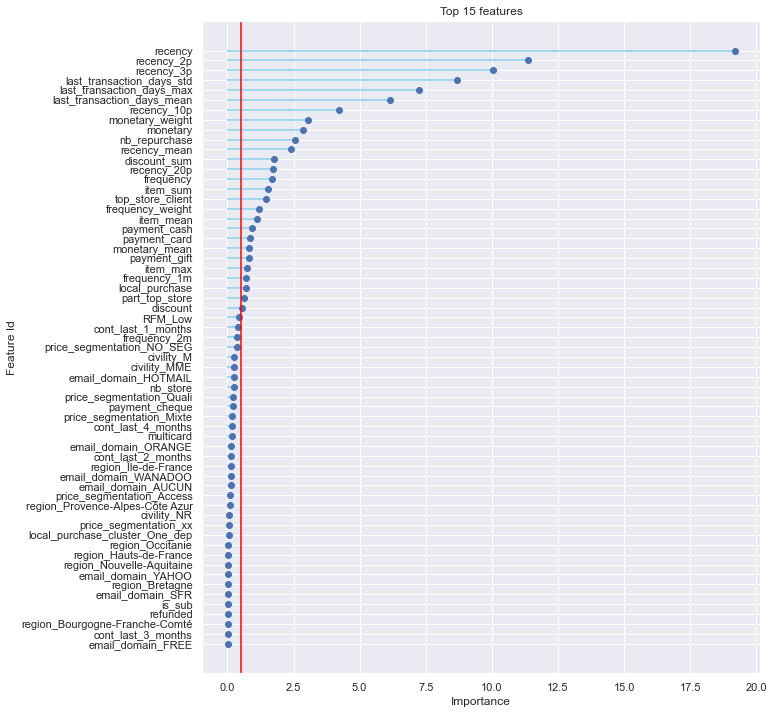

In [160]:
fig = plt.figure(1, figsize=(10,12))

# Reorder it based on the values
ordered_df = best_feats.sort_values(by='Importances').iloc[15:]
my_range=range(1, len(ordered_df.index)+1)
 
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Importances'], color='skyblue')
plt.plot(ordered_df['Importances'], my_range, "o")
plt.axvline(x=0.5, color='red')

# Add titles and axis names
plt.yticks(my_range, ordered_df['Feature Id'])
plt.xlabel('Importance')
plt.ylabel('Feature Id')
plt.title('Top 15 features')

# Show the plot
plt.show()

In [96]:
X_test_kaggle[ls_best_feats]

,recency,recency_2p,recency_3p,recency_10p,last_transaction_days_sd,last_transaction_days_mean,recency_20p,last_transaction_days_max,recency_mean,top_store_client,nb_repurchase,item_sum,monetary,discount_sum,payment_card,frequency,frequency_weight,RFM_Medium,frequency_2m,item_mean,monetary_weight,item_max,payment_gift,discount,monetary_mean,payment_cash,part_top_store,price_segmentation_NO_SEG
0,8,21,28,133,7.359423,9.694444,200,42.0,187.111111,44,12,577,1644.56,52.98,0.722222,36,6736,1,2,16.027778,302002.87,45,0.166667,0.472222,45.682222,0.194444,1.000000,0
1,0,3,5,26,2.589057,3.514563,53,16.0,182.349515,44,12,1372,4228.46,57.11,0.786408,103,18782,1,2,13.320388,802759.84,31,0.009709,0.252427,41.053010,0.077670,1.000000,0
2,2,7,8,32,4.074931,4.550000,57,24.0,153.787500,392,12,834,2038.59,195.78,0.925000,80,12303,1,2,10.425000,477626.41,34,0.012500,0.437500,25.482375,0.012500,0.975000,0
3,3,17,24,80,1.666274,7.058824,143,14.0,186.450980,58,12,789,1946.01,50.27,0.000000,51,9509,1,2,15.470588,374984.64,30,0.039216,0.117647,38.157059,0.019608,1.000000,0
4,0,7,14,63,2.470249,6.403509,140,14.0,195.000000,72,12,1478,4044.12,324.82,0.982456,57,11115,1,2,25.929825,800117.30,48,0.105263,0.596491,70.949474,0.017544,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40101,178,179,181,198,12.313470,1.674312,206,178.0,300.605505,178,7,6166,39841.08,6462.12,0.477064,218,65532,0,2,28.284404,2502857.20,155,0.724771,0.990826,182.757248,0.160550,0.995413,1
40102,0,1,2,4,0.539894,0.293881,13,4.0,214.499195,276,12,13618,123886.24,29219.42,0.314815,1242,266408,0,2,10.964573,19635327.61,221,0.437198,0.995974,99.747375,0.078905,0.296296,0
40103,6,6,6,7,0.396915,0.114680,7,6.0,175.105009,1,11,13293,32736.01,231.32,0.346114,2895,506929,0,2,4.591710,6772186.28,66,0.003454,0.037306,11.307775,0.547150,1.000000,1
40104,1,5,7,33,0.679272,0.180195,42,12.0,125.304383,5,8,19181,48048.98,93.83,0.606331,1232,154375,0,2,15.568994,11747839.62,89,0.027597,0.042208,39.000795,0.336039,1.000000,1


In [163]:
# Keep only the best feature

X_train = X_train[ls_best_feats]
X_test = X_test[ls_best_feats]
X_test_kaggle = X_test_kaggle[ls_best_feats]
X = X[ls_best_feats]

### **II.3 Multicollinearity**

In [166]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
    ('correlation', SmartCorrelatedSelection(selection_method='variance')),
])

pipe.fit(X)
X = pipe.transform(X)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160424 entries, 0 to 160423
Data columns (total 59 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   recency_2p                       160424 non-null  float64
 1   recency_20p                      160424 non-null  float64
 2   recency_mean                     160424 non-null  float64
 3   monetary_mean                    160424 non-null  float64
 4   item_max                         160424 non-null  float64
 5   last_transaction_days_max        160424 non-null  float64
 6   last_transaction_days_std        160424 non-null  float64
 7   discount_sum                     160424 non-null  float64
 8   discount                         160424 non-null  float64
 9   refunded                         160424 non-null  float64
 10  part_top_store                   160424 non-null  float64
 11  nb_repurchase                    160424 non-null  float64
 12  pa

In [ ]:
pipe = Pipeline([
  ('constant', DropConstantFeatures(tol=0.998)),
  ('duplicated', DropDuplicateFeatures()),
  ('correlation', SmartCorrelatedSelection(selection_method='variance')),
])

pipe.fit(pd.DataFrame(pd.DataFrame(X_test_kaggle[ls_best_feats])))
X_test_kaggle_cleaned = pipe.transform(pd.DataFrame(X_test_kaggle[ls_best_feats]))

SmartCorrelatedSelection() finds groups of correlated features and then selects, from each group, a feature following certain criteria:

*   Feature with least missing values
*   Feature with most unique values
*   Feature with highest variance

X_test_kaggle_cleaned is thus a dataframe with the features that are not constant, not duplicated and that were selected with SmartCorrelatedSelection() (the criteria is the variance). 

### **II.4 Model selection**

We test serveral model to find the best (with logloss score).

In [ ]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
#models.append(("SVC", SVC())) # Take several minutes to run
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("XGBClassifier", XGBClassifier(eval_metric='mlogloss')))
#models.append(("KNeighborsClassifier", KNeighborsClassifier())) # Take several minutes to run
models.append(("LGBMClassifier", LGBMClassifier()))
models.append(("CatBoostClassifier", CatBoostClassifier()))

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [],
                     'logloss'    : [],
                     'time'       : []}

# For each model name and model in models
for model_name, model in models:
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_result = cross_val_score(model, X, y, cv = kfold, n_jobs=-1, scoring = metrics.make_scorer(metrics.log_loss))
    
    model_scores_dict['logloss'].append(cv_result.mean())
    model_scores_dict['time'].append((time.time() - start))
    
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["logloss", "time"])

The LightGBM is the best model like always !

### **II.5 LightGBM, Catboost and stacked models**

### **Cross validation**

We perform the cross validation to estimate our model precision.

In [167]:
# A function for the Cross Validation with LightGBM model
def run_model():
    model = LGBMClassifier(num_leaves=15, #15
                           max_depth=8, #12
                           random_state=314, 
                           verbose=0, 
                           metric='logloss', 
                           n_jobs=-1, 
                           n_estimators=300,
                           colsample_bytree=0.8,
                           subsample=0.9,
                           learning_rate=0.05,
                           force_row_wise=True)
    
    clf = CatBoostClassifier(
        iterations= 1000,
        random_seed=314,
        learning_rate= 0.02,
        objective = 'Logloss',
    )
    
    #model = LGBMClassifier(**best_params)
    
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #cv = cross_val_score(model, X, y, cv = kfold, n_jobs=-1, scoring = metrics.make_scorer(metrics.log_loss))
    def score(estimator, X, y):
        return metrics.log_loss(y, estimator.predict_proba(X))
    
    cv = cross_val_score(clf, X, y, cv = kfold, n_jobs=-1, scoring=score)
    print(cv)
    return cv.mean()

run_model()

# CatBoost : 19472
# LGBM : 19488
# LGBM : 19482

# CatBoost Without Outlier cleaning : 19463
# 19471
# 19476
# 19470

[0.2003836  0.20057843 0.19354888 0.1990363  0.20153108 0.19541767
 0.19528638 0.20330891 0.20189252 0.20225329 0.19817137 0.19926239
 0.19537649 0.20139051 0.19876976 0.20445592 0.1959451  0.20030642
 0.19922796 0.1979781  0.19651907 0.19685432 0.19740141 0.20245403
 0.19984013 0.2005654  0.20457872 0.19896187 0.19493158 0.1998388 ]


0.19920221352281178

### **Model for prediction** : LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9880, number of negative: 118459
[LightGBM] [Info] Total Bins 6828
[LightGBM] [Info] Number of data points in the train set: 128339, number of used features: 76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076984 -> initscore=-2.484054
[LightGBM] [Info] Start training from score -2.484054
Training accuracy 0.9315
Testing accuracy 0.9270
Testing Logloss 2.5200
Testing Prob Logloss 0.1986


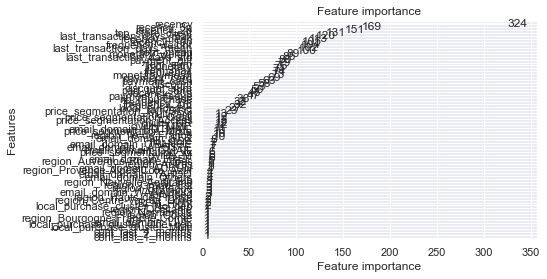

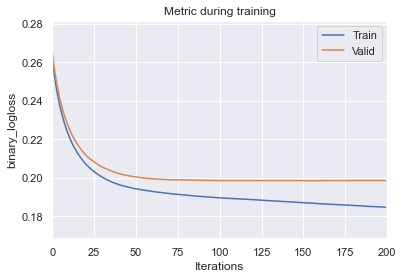

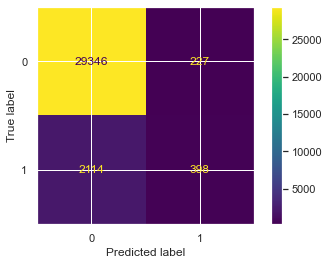

In [248]:
# LightGBM model

lgbm_params = {
    "num_leaves":15,
    "max_depth":-1,
    "force_row_wise":True,
    "random_state":46,
    "verbose":1,
    "metric":'logloss',
    "n_jobs":4,
    "n_estimators":200,
    "colsample_bytree":0.9,
    "subsample":0.9,
    "learning_rate":0.05,
}

fit_params={"eval_metric" : 'logloss', 
            "eval_set" : [(X_test,y_test),(X_train,y_train)],
            'eval_names': ["Valid", "Train"],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

model_lgbm = LGBMClassifier(**lgbm_params)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_lgbm.fit(X_train, y_train, **fit_params, verbose=False)

# Estimate Logloss
plot_importance(model_lgbm) # Graph for the feature importance
plot_metric(model_lgbm) # Graph for the binary_logloss evolution
metrics.ConfusionMatrixDisplay.from_predictions(y_test, model_lgbm.predict(X_test)) # Confusion matrix

print('Training accuracy {:.4f}'.format(model_lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model_lgbm.score(X_test,y_test)))
print('Testing Logloss {:.4f}'.format(metrics.log_loss(y_test, model_lgbm.predict(X_test))))
print('Testing Prob Logloss {:.4f}'.format(metrics.log_loss(y_test, model_lgbm.predict_proba(X_test))))

### **Model for prediction** :  Catboost

Training accuracy 0.9334
Testing accuracy 0.9276
Testing Logloss 2.5017
Testing Prob Logloss 0.1984


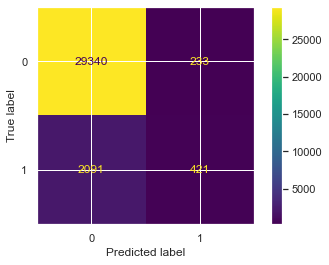

In [249]:
## Catboost parametrisation
clf = CatBoostClassifier(
    iterations=1000,
    random_seed=314,
    learning_rate=0.05,
    objective ='Logloss',
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clf.fit(X_train, y_train, verbose=False)

# Estimate Logloss
metrics.ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test)) # Confusion matrix

print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))
print('Testing Logloss {:.4f}'.format(metrics.log_loss(y_test, model.predict(X_test))))
print('Testing Prob Logloss {:.4f}'.format(metrics.log_loss(y_test, model.predict_proba(X_test))))

## **Stacked** 

In [200]:
NFOLDS = 8
SEED = 0

class ModelWrapper(object):
    def __init__(self, clf, seed=0, **params):
        self.params = params
        self.model = clf(**params)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict_proba(X)[:,1]
    
    def get_oof(self, X, y, X_test_kaggle):
        oof_train = np.zeros((len(X),))
        oof_test = np.zeros((len(X_test_kaggle),))
        oof_test_skf = np.empty((NFOLDS, len(X_test_kaggle)))
        logloss_result = np.empty(8)
        kf = StratifiedKFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

        for i, (train_index, test_index) in enumerate(kf.split(X, y)):
            X_tr = X.loc[train_index]
            y_tr = y.loc[train_index]
            X_te = X.loc[test_index]

            self.train(X_tr, y_tr)

            oof_train[test_index] = self.predict(X_te)
            oof_test_skf[i, :] = self.predict(X_test_kaggle)
            
            logloss_result[i] = log_loss(y.loc[test_index], oof_train[test_index])
            print(f"fold {i+1}/{NFOLDS}", logloss_result[i])

        oof_test[:] = oof_test_skf.mean(axis=0)        
        print(f"Logloss : ", logloss_result.mean())
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [203]:
lightgbm_params = {
    'num_leaves': 15,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_lambda': 0.8,
    'reg_alpha': 0.25,
    'min_child_weight': 3,
    'n_estimators':300,
    'learning_rate': 0.05,
    'metric': 'logloss',
    'n_jobs': -1,
    'force_row_wise': True,
}

catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'objective': 'Logloss',
    'verbose': False,
}

lggm_model = ModelWrapper(LGBMClassifier, **lightgbm_params)
lg_oof_train, lg_oof_test = lggm_model.get_oof(X, y, X_test_kaggle)

cb_model = ModelWrapper(CatBoostClassifier, **catboost_params)
cb_oof_train, cb_oof_test = cb_model.get_oof(X, y, X_test_kaggle)

fold 1/8 0.1968156802691439
fold 2/8 0.19177542287476648
fold 3/8 0.19448525628438149
fold 4/8 0.19265305876836003
fold 5/8 0.20184283842387052
fold 6/8 0.1933142614184765
fold 7/8 0.1923373379023169
fold 8/8 0.19465800527435023
Logloss :  0.19473523265195825
fold 1/8 0.19659603618666557
fold 2/8 0.19176088901923827
fold 3/8 0.19432863971607348
fold 4/8 0.1927771415346799
fold 5/8 0.20213397774465858
fold 6/8 0.1929207044153073
fold 7/8 0.19322762998662507
fold 8/8 0.19446845780395144
Logloss :  0.19477668455089994


In [240]:
y.values

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [244]:
weights = [0.2, 0.8]
y_pred = np.sum(np.concatenate((lg_oof_train, cb_oof_train), axis=1) * weights, axis=1)
y_test_pred = np.sum(np.concatenate((lg_oof_test, cb_oof_test), axis=1) * weights, axis=1)

print('Testing Prob Logloss {:.4f}'.format(metrics.log_loss(y, y_pred)))

Testing Prob Logloss 0.1946


## **III. Prediction**

#### **LGBM**

Perform the prediction with the real test sets for submission.

#### **Stacked model: LightGBM**

In [ ]:
df_test["repurchase"] = model_lgbm.predict_proba(X_test_kaggle)[:,1]
df_test[["id_client", "repurchase"]].to_csv("submission.csv", index=False)

#### **Stacked model: LBGM + Catboost**

In [246]:
df_test["repurchase"] = y_test_pred
df_test[["id_client", "repurchase"]].to_csv("submission.csv", index=False)

#### Kaggle submit cmd

In [ ]:
#kaggle competitions submit  -c tse-mkg-eco-2021-project2 -f submission.csv -m "Message"